In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import pandas as pd
import numpy as np
import pyodbc as py

import warnings

from datetime import date, timedelta, datetime
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

from sklearn import neighbors
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import importlib
import functions
importlib.reload(functions)

pd.set_option('display.max_columns', None)

In [3]:
warnings.filterwarnings('ignore')

# Data Loading

## Option 1: via Data_Cleaning_Preparation code (preferred) -> load in .csv file

In [4]:
df = pd.read_csv('/Users/thoma/Documents/seminar_data/cleaned_prepared_data.csv', low_memory = True)

In [5]:
df['orderDate'] = pd.to_datetime(df['orderDate'])
df['cancellationDate'] = pd.to_datetime(df['cancellationDate'])
df['promisedDeliveryDate'] = pd.to_datetime(df['promisedDeliveryDate'])
df['shipmentDate'] = pd.to_datetime(df['shipmentDate'])
df['dateTimeFirstDeliveryMoment'] = pd.to_datetime(df['dateTimeFirstDeliveryMoment'])
df['startDateCase'] = pd.to_datetime(df['startDateCase'])
df['returnDateTime'] = pd.to_datetime(df['returnDateTime'])
df['registrationDateSeller'] = pd.to_datetime(df['registrationDateSeller'])

In [6]:
historic_variable = ['transporterCode','sellerId','productGroup']

In [7]:
df['binaryHappyMatchClassification'] = df['generalMatchClassification'].apply(lambda x: 'HAPPY' if x == 'HAPPY' else 'REST')
df['binaryUnhappyMatchClassification'] = df['generalMatchClassification'].apply(lambda x: 'UNHAPPY' if x == 'UNHAPPY' else 'REST')

In [8]:
#Fixed Columns:
DATE = ['orderDate']
BASIC = ['totalPrice','quantityOrdered','fulfilmentByBol','countryCodeNL','countryOriginNL','countryOriginBE',
        'countryOriginDE','productTitleLength','promisedDeliveryDays','partnerSellingDays', 'orderCorona']
WEEK = ['orderMonday','orderTuesday','orderWednesday','orderThursday','orderFriday','orderSaturday','orderSunday']
MONTH = ['orderJanuary','orderFebruary','orderMarch','orderApril','orderMay','orderJune',
         'orderJuly','orderAugust','orderSeptember','orderOctober','orderNovember','orderDecember']
YEAR = ['orderYear2020']
GROUP = ['groupHealth','groupHome','groupSports','groupComputer','groupPets','groupToys','groupBooks', 
         'groupBaby', 'groupMusic', 'groupFood','groupOffice','groupFashion','groupOther','groupCar']

#Dynamic Columns:
TRANSPORTERX = ['transporterPOSTNL/X','transporterDHL/X','transporterDPD/X','transporterBRIEF/X','transporterOTHER/X']
KNOWNX = ['caseKnownX','returnKnownX','cancellationKnownX','onTimeDeliveryKnownX','lateDeliveryKnownX']
PRODUCTX = ['productOrderCountX','productTotalCountX','productTotalReturnedX','productReturnFractionX']
SELLERX = ['sellerDailyOrdersX']
HISTORICX = []
for x in range(len(historic_variable)):
    HISTORICX = HISTORICX + [historic_variable[x]+'HistoricHappyX',historic_variable[x]+'HistoricUnhappyX',historic_variable[x]+'HistoricUnknownX']

#Determinants
DETERMINANT = ['noReturn', 'noCase', 'noCancellation', 'onTimeDelivery']

#Classifications
CLASSIFICATION = ['generalMatchClassification','detailedMatchClassification','binaryMatchClassification',
                  'binaryHappyMatchClassification','binaryUnhappyMatchClassification','determinantClassification']

## Option 2: via direct sql connection

In [5]:
connection_string = (    
    r'Driver={SQL Server};'
    r'Server=LAPTOP-LD74USH0\SQLEXPRESS;'
    r'Integrated Security=SSPI;'
    r'Trusted_Connection=yes;'
)
pd.set_option('display.max_columns', None)

In [6]:
def sql2df(query, params=[], parse_dates=None, dsn='SQLEXPRESS'):
        with py.connect(connection_string, readonly=True) as conn:
            return pd.read_sql(query, conn, params=params, parse_dates=parse_dates)

In [7]:
# First work with random top 100.000 (to reduce computation time) - 45secs

df = sql2df('''
SELECT TOP 500000 * FROM Seminar.dbo.cleaned_bol_data_full
ORDER BY newid();
''')


In [321]:
# 9.5 minutes 

df = sql2df('''
SELECT * FROM Seminar.dbo.cleaned_bol_data_full;
''')

In [8]:
#Change type of columns
dtype = {'calculationDefinitive': bool,
         'noCancellation': bool,
         'noCase': bool,
         'hasOneCase': bool,
         'hasMoreCases': bool,
         'noReturn': bool,
         'orderWeekend': bool,
         'orderCorona': bool,
         'countryCodeNL': bool,
         'fulfilmentByBol': bool,
         'countryOriginNL': bool,
         'countryOriginBE': bool,
         'countryOriginDE': bool,
         'orderMonday': bool,
         'orderTuesday': bool,
         'orderWednesday': bool,
         'orderThursday': bool,
         'orderFriday': bool,
         'orderSaturday': bool,
         'orderSunday': bool,
         'orderJanuary': bool,
         'orderFebruary': bool,
         'orderMarch': bool,
         'orderApril': bool,
         'orderMay': bool,
         'orderJune': bool,
         'orderJuly': bool,
         'orderAugust': bool,
         'orderSeptember': bool,
         'orderOctober': bool,
         'orderNovember': bool,
         'orderDecember': bool}

df = df.astype(dtype)

#Transform dates to date-type
df['orderDate'] = pd.to_datetime(df['orderDate'], errors='coerce')
df['cancellationDate'] = pd.to_datetime(df['cancellationDate'], errors='coerce')
df['promisedDeliveryDate'] = pd.to_datetime(df['promisedDeliveryDate'], errors='coerce')
df['shipmentDate'] = pd.to_datetime(df['shipmentDate'], errors='coerce')
df['dateTimeFirstDeliveryMoment'] = pd.to_datetime(df['dateTimeFirstDeliveryMoment'], errors='coerce')
df['startDateCase'] = pd.to_datetime(df['startDateCase'], errors='coerce')
df['returnDateTime'] = pd.to_datetime(df['returnDateTime'], errors='coerce')
df['registrationDateSeller'] = pd.to_datetime(df['registrationDateSeller'], errors='coerce')

df.dtypes

orderDate             datetime64[ns]
productId                     object
sellerId                      object
totalPrice                   float64
quantityOrdered                int64
                           ...      
orderSeptember                  bool
orderOctober                    bool
orderNovember                   bool
orderDecember                   bool
productTitleLength             int64
Length: 78, dtype: object

#### Add variables

In [9]:
# Binary classification variable
df['binaryMatchClassification'] = df['generalMatchClassification'].apply(lambda x: 'UNKNOWN' if x == 'UNKNOWN' else 'KNOWN')

# Dummy for year = 2020
df['orderYear2020'] = df['orderYear'].apply(lambda x: True if x == 2020 else False)

#### Transporter Groups

In [10]:
def transporterCluster(transporterCode):
    """
    Function to create a new manually clustered transporter variable: 28 -> 5 categories
    """
    if transporterCode in ['AH-NL','TNT','TNT-EXPRESS','TNT-EXTRA']:
        return 'POSTNL'
    elif transporterCode in ['DHL','DHL_DE','DHLFORYOU']:
        return 'DHL'
    elif transporterCode in ['DPD-NL','DPD-BE']:
        return 'DPD'
    elif transporterCode in ['BRIEFPOST','BPOST_BE','BPOST_BRIEF','DHL-GLOBAL-MAIL','TNT_BRIEF']:
        return 'BRIEF'
    else:
        return 'OTHER'

In [11]:
df['transporterCodeGeneral'] = df['transporterCode'].apply(transporterCluster)
df['transporterCodeGeneral'].value_counts()

POSTNL    221508
BRIEF     165035
DHL        45527
DPD        34475
OTHER      33455
Name: transporterCodeGeneral, dtype: int64

#### Product Groups

In [12]:
def productGroupCluster(productGroup):
    """
    Function to create a new manually clustered product group variable based on categories bol.com
    60 -> 14 groups.
    """
    if productGroup in ['Dutch Books PG','Ebooks and Audiobooks','International Books PG']:
        return 'Books'
    elif productGroup in ['Games Accessories','Games Consoles','Games Software Physical',
                          'Movies','Music']:
        return 'Music, Film & Games'
    elif productGroup in ['Camera','Desktop Monitor and Beamer','Ereaders and Accessories',
                          'Laptop Computers','PC Accessories','Personal Audio',
                          'Sound and Vision Accessories','Storage and Network',
                          'Telephone and Tablet Accessories','Telephones and Tablets','Television']:
        return 'Computer & Electronics'
    elif productGroup in ['General Toys','Recreational and Outdoor Toys']:
        return 'Toys & Hobby'
    elif productGroup in ['Baby and Kids Fashion','Baby PG']:
        return 'Baby & Kids'
    elif productGroup in ['Daily Care PG','Health PG','Perfumery PG','Personal Care']:
        return 'Health & Care'
    elif productGroup in ['Footwear','Jewelry and Watches','Mens and Womens Fashion','Wearables']:
        return 'Fashion, Shoes & Accessories'
    elif productGroup in ['Bodyfashion and Beachwear','Camping and Outdoor','Cycling',
                          'Sporting Equipment','Sportswear','Travel Bags and Accessories']:
        return 'Sports, Outdoor & Travel'
    elif productGroup in ['Educational Dutch','Educational International','Printing and Ink']:
        return 'Office & School'
    elif productGroup in ['Supermarket PG'] :
        return 'Food & Beverage'
    elif productGroup in ['Furniture','Heating and Air','Home Decoration','Home Entertainment',
                          'Household','Household Appliances','Kitchen','Kitchen Machines',
                          'Lighting','Major Domestic Appliances PG','Plumbing and Safety']:
        return 'Home, Cooking & Household'
    elif productGroup in ['Garden','Pet PG','Textiles','Tools and Paint']:
        return 'Pets, Garden & Jobs'
    elif productGroup in ['Car and Motorcycle'] :
        return 'Car & Motor'
    else:
        return 'Other'

In [13]:
df['productGroupGeneral'] = df['productGroup'].apply(productGroupCluster)
df['productGroupGeneral'].value_counts()

Computer & Electronics          145687
Home, Cooking & Household        83348
Sports, Outdoor & Travel         54598
Toys & Hobby                     52834
Pets, Garden & Jobs              35484
Health & Care                    31315
Food & Beverage                  26802
Books                            19435
Music, Film & Games              17343
Baby & Kids                      11784
Fashion, Shoes & Accessories     11453
Office & School                   5450
Car & Motor                       3149
Other                             1318
Name: productGroupGeneral, dtype: int64

In [14]:
#Create dummies of new product grouping
for group in df['productGroupGeneral'].unique():
    
    columnName = 'group' + group.split(' ')[0].replace(',','')
    df[columnName] = df['productGroupGeneral'].apply(lambda x: True if x == group else False)

In [15]:
print(df.columns)
print('Total: ',len(df.columns),' columns')

Index(['orderDate', 'productId', 'sellerId', 'totalPrice', 'quantityOrdered',
       'countryCode', 'cancellationDate', 'cancellationReasonCode',
       'promisedDeliveryDate', 'shipmentDate', 'transporterCode',
       'transporterName', 'transporterNameOther',
       'dateTimeFirstDeliveryMoment', 'fulfilmentType', 'startDateCase',
       'cntDistinctCaseIds', 'returnDateTime', 'quantityReturned',
       'returnCode', 'productTitle', 'brickName', 'chunkName', 'productGroup',
       'productSubGroup', 'productSubSubGroup', 'registrationDateSeller',
       'countryOriginSeller', 'currentCountryAvailabilitySeller',
       'calculationDefinitive', 'noCancellation', 'onTimeDelivery', 'noCase',
       'hasOneCase', 'hasMoreCases', 'noReturn', 'detailedMatchClassification',
       'generalMatchClassification', 'determinantClassification', 'orderYear',
       'orderMonth', 'orderYearMonth', 'orderWeekday', 'orderWeekend',
       'orderCorona', 'transporterFeature', 'partnerSellingMonths',
   

In [16]:
#Fixed Columns:
BASIC = ['totalPrice','quantityOrdered','fulfilmentByBol','countryCodeNL','countryOriginNL','countryOriginBE',
        'countryOriginDE','productTitleLength']
WEEK = ['orderMonday','orderTuesday','orderWednesday','orderThursday','orderFriday','orderSaturday','orderSunday']
MONTH = ['orderJanuary','orderFebruary','orderMarch','orderApril','orderMay','orderJune',
         'orderJuly','orderAugust','orderSeptember','orderOctober','orderNovember','orderDecember']
GROUP = ['groupHealth','groupHome','groupSports','groupComputer','groupPets','groupToys','groupBooks', 
         'groupBaby', 'groupMusic', 'groupFood','groupOffice','groupFashion','groupOther','groupCar']

#Dynamic Columns:
TRANSPORTERX = ['transporterPOSTNL/X','transporterDHL/X','transporterDPD/X','transporterBRIEF/X','transporterOTHER/X']
KNOWNX = ['caseKnownX','returnKnownX','cancellationKnownX','onTimeDeliveryKnownX','lateDeliveryKnownX']
PRODUCTX = ['productOrderCountX','productTotalCountX','productTotalReturnedX','productReturnFractionX']
SELLERX = ['sellerDailyOrdersX']

#Classifications
CLASS = ['generalMatchClassification']

# Create Sample

In [9]:
X_col = BASIC + WEEK + MONTH + YEAR + GROUP + TRANSPORTERX + KNOWNX + PRODUCTX + SELLERX + HISTORICX
y_col = [CLASSIFICATION[1]]  # Match label prediction
#y_col = [CLASSIFICATION[4]]  # Binary classification

#df_sample = df
df_sample = df.sample(n = 100000, replace = False, random_state = 0)

In [12]:
# dataX already sorts per order Date
X, y = functions.dataX(df_sample, DATE, X_col, y_col, historic_variable, 0)

In [27]:
for i in range(3):
    X_train_val = X.iloc[int(0.1*i):int(0.1*i+0.5*len(X))]
    X_train = X_train_val.iloc[0:int(0.8*len(X_train_val))]
    X_val = X_train_val.iloc[int(0.8*len(X_train_val)):]

In [30]:
X_train_val
X_train
X_val

,totalPrice,quantityOrdered,fulfilmentByBol,countryCodeNL,countryOriginNL,countryOriginBE,countryOriginDE,productTitleLength,promisedDeliveryDays,partnerSellingDays,orderCorona,orderMonday,orderTuesday,orderWednesday,orderThursday,orderFriday,orderSaturday,orderSunday,orderJanuary,orderFebruary,orderMarch,orderApril,orderMay,orderJune,orderJuly,orderAugust,orderSeptember,orderOctober,orderNovember,orderDecember,orderYear2020,groupHealth,groupHome,groupSports,groupComputer,groupPets,groupToys,groupBooks,groupBaby,groupMusic,groupFood,groupOffice,groupFashion,groupOther,groupCar,transporterPOSTNL/X,transporterDHL/X,transporterDPD/X,transporterBRIEF/X,transporterOTHER/X,caseKnownX,returnKnownX,cancellationKnownX,onTimeDeliveryKnownX,lateDeliveryKnownX,productOrderCountX,productTotalCountX,productTotalReturnedX,productReturnFractionX,sellerDailyOrdersX,transporterCodeHistoricHappyX,transporterCodeHistoricUnhappyX,transporterCodeHistoricUnknownX,sellerIdHistoricHappyX,sellerIdHistoricUnhappyX,sellerIdHistoricUnknownX,productGroupHistoricHappyX,productGroupHistoricUnhappyX,productGroupHistoricUnknownX
40000,2.420368,1,False,True,True,False,False,97,3,997,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,1,1,0.0,0.000000,-2.965273,85.85,10.76,3.39,66.67,33.33,0.00,69.50,12.20,18.30
40001,3.399529,1,False,True,True,False,False,66,3,2341,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,19,19,2.0,0.105263,2.898929,86.16,11.97,1.87,13.38,9.26,77.36,21.59,10.52,67.89
40002,2.106570,1,False,True,True,False,False,47,3,2341,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,24,27,0.0,0.000000,2.898929,86.16,11.97,1.87,13.38,9.26,77.36,21.59,10.52,67.89
40003,2.704711,1,False,True,True,False,False,82,3,2341,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,4,4,1.0,0.250000,2.898929,86.16,11.97,1.87,13.38,9.26,77.36,21.59,10.52,67.89
40004,2.704711,1,False,True,True,False,False,39,3,2341,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,1,0.0,0.000000,2.898929,0.00,8.55,91.45,13.38,9.26,77.36,21.59,10.52,67.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,3.042139,1,False,True,True,False,False,65,2,729,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,2,0.0,0.000000,-0.604632,0.00,10.42,89.58,0.00,10.57,89.43,70.22,11.67,18.10
49996,1.902108,1,False,True,True,False,False,35,1,1736,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Fals

In [24]:
X.iloc[0:int(0.5*len(X))]

,totalPrice,quantityOrdered,fulfilmentByBol,countryCodeNL,countryOriginNL,countryOriginBE,countryOriginDE,productTitleLength,promisedDeliveryDays,partnerSellingDays,orderCorona,orderMonday,orderTuesday,orderWednesday,orderThursday,orderFriday,orderSaturday,orderSunday,orderJanuary,orderFebruary,orderMarch,orderApril,orderMay,orderJune,orderJuly,orderAugust,orderSeptember,orderOctober,orderNovember,orderDecember,orderYear2020,groupHealth,groupHome,groupSports,groupComputer,groupPets,groupToys,groupBooks,groupBaby,groupMusic,groupFood,groupOffice,groupFashion,groupOther,groupCar,transporterPOSTNL/X,transporterDHL/X,transporterDPD/X,transporterBRIEF/X,transporterOTHER/X,caseKnownX,returnKnownX,cancellationKnownX,onTimeDeliveryKnownX,lateDeliveryKnownX,productOrderCountX,productTotalCountX,productTotalReturnedX,productReturnFractionX,sellerDailyOrdersX,transporterCodeHistoricHappyX,transporterCodeHistoricUnhappyX,transporterCodeHistoricUnknownX,sellerIdHistoricHappyX,sellerIdHistoricUnhappyX,sellerIdHistoricUnknownX,productGroupHistoricHappyX,productGroupHistoricUnhappyX,productGroupHistoricUnknownX
0,4.700026,1,False,True,True,False,False,58,2,1502,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,1,0.0,0.0,0.693147,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,4.094178,1,True,True,True,False,False,44,2,2236,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,1,0.0,0.0,0.693147,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3.218476,1,False,True,True,False,False,53,2,2236,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,1,0.0,0.0,0.693147,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1.783391,1,False,True,True,False,False,116,2,925,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,1,0.0,0.0,0.693147,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,4.710431,1,False,True,True,False,False,57,3,1328,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,1,1,0.0,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,3.042139,1,False,True,True,False,False,65,2,729,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,2,0.0,0.0,-0.604632,0.00,10.42,89.58,0.00,10.57,89.43,70.22,11.67,18.10
49996,1.902108,1,False,True,True,False,False,35,1,1736,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False

In [15]:
tscv = TimeSeriesSplit(n_splits = 3)
for train_index, test_index in tscv.split(X):
    X_train, X_val = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

[['orderDate'],
        totalPrice  quantityOrdered  fulfilmentByBol  countryCodeNL  \
 0        4.700026                1            False           True   
 1        4.094178                1             True           True   
 2        3.218476                1            False           True   
 3        1.783391                1            False           True   
 4        4.710431                1            False           True   
 ...           ...              ...              ...            ...   
 99995    2.830268                1             True           True   
 99996    3.921973                1            False          False   
 99997    2.350422                1             True           True   
 99998    3.216874                1             True           True   
 99999    4.381902                1             True          False   
 
        countryOriginNL  countryOriginBE  countryOriginDE  productTitleLength  \
 0                 True            False         

In [ ]:
tscv = TimeSeriesSplit(n_splits = 3)
        
for train_index, test_index in tscv.split(X):

# Function-based Classification

## Classification

In [10]:
def classificationPerformanceOverTime(df, DATE, X_col, y_col, DAYS, estimator, REP, splitType = 'TimeSeries', smoteActive = False, scaler = None, NN_estimator = False):
    resultDic = {}
    
    for days in range(DAYS):
        X, y = functions.dataX(df, DATE, X_col, y_col, historic_variable, days)
        result = functions.classifyLabelsNew(estimator, X, y, REP, splitType, smoteActive, scaler, NN_estimator)
        resultDic[days] = result
        print('DAYS: ', days)
    
    RESULT = pd.DataFrame.from_dict(resultDic, orient = 'index')
    return(RESULT)

In [11]:
def featureSelection(X_train, y_train, X_test): # allow model to train from as input (currently RF) and allow type of selection as input and allow max_features
    fs = SelectFromModel(RandomForestClassifier(n_estimators=50,random_state=0,class_weight='balanced'), max_features=30)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [54]:
tscv = TimeSeriesSplit(n_splits = 3)

accuracy = {}
class_report = {}
count = 1

X, y = functions.dataX(df_sample, DATE, X_col, y_col, historic_variable, 5)

for train_index, test_index in tscv.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_fs, X_test_fs, fs = featureSelection(X_train, y_train, X_test)
    feature_indices = fs.get_support(indices=True)
    X_col_fs = []
    for j in range(len(feature_indices)):
        X_col_fs.append(X_col[feature_indices[j]])
    
    #clf = DecisionTreeClassifier(random_state=0,
                                 #class_weight='balanced')
    clf = RandomForestClassifier(n_estimators=10,random_state=0,class_weight='balanced')
    #clf = LogisticRegression(random_state=0,class_weight='balanced',fit_intercept=False,solver='liblinear')
    #clf = GradientBoostingClassifier(random_state=0)
    # clf = HistGradientBoostingClassifier(random_state=0)
    #clf = BaggingClassifier(n_estimators=10,random_state=0) 
    #clf = BernoulliNB()
    #clf = neighbors.KNeighborsClassifier(n_neighbors = 3)
    #clf = svm.SVC(random_state=0, kernel='linear', decision_function_shape = 'ovo')
    
    clf = clf.fit(X_train_fs,y_train)

    prediction = clf.predict(X_test_fs)
    
    accuracy[count] = metrics.accuracy_score(y_test, prediction)
    class_report[count] = metrics.classification_report(y_test, prediction)
    
    print(count)
    count += 1

1
2
3


In [55]:
for item in class_report.values():
    print(item)

              precision    recall  f1-score   support

       HAPPY       0.97      0.99      0.98     67854
     UNHAPPY       0.91      0.68      0.78     15402
     UNKNOWN       0.93      0.98      0.96     41744

    accuracy                           0.95    125000
   macro avg       0.94      0.88      0.91    125000
weighted avg       0.95      0.95      0.95    125000

              precision    recall  f1-score   support

       HAPPY       0.97      0.99      0.98     76133
     UNHAPPY       0.93      0.67      0.78     14676
     UNKNOWN       0.90      0.98      0.94     34191

    accuracy                           0.95    125000
   macro avg       0.94      0.88      0.90    125000
weighted avg       0.95      0.95      0.95    125000

              precision    recall  f1-score   support

       HAPPY       0.97      0.99      0.98     70112
     UNHAPPY       0.93      0.71      0.80     14614
     UNKNOWN       0.93      0.98      0.96     40274

    accuracy        

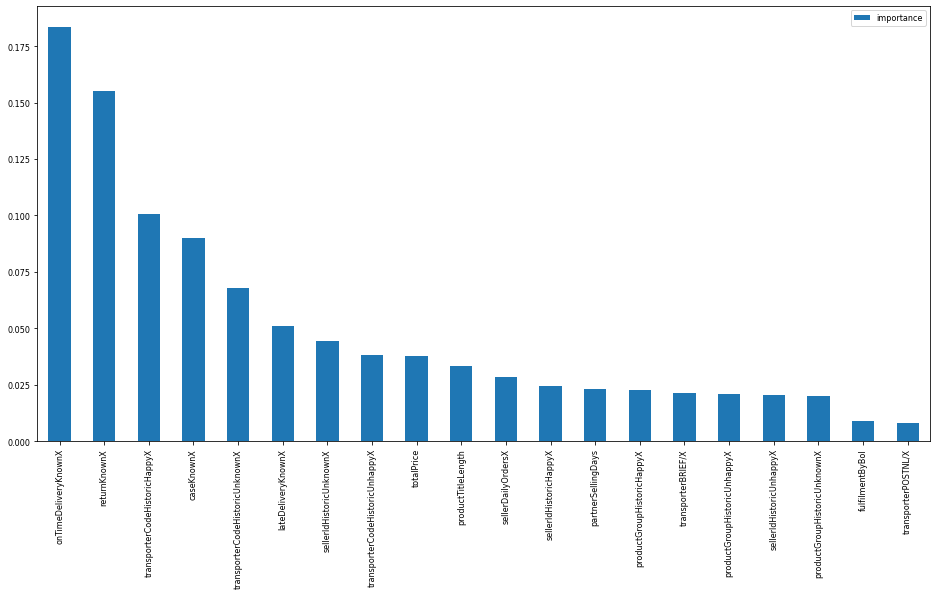

In [56]:
plt.rcParams.update({'font.size': 8})
importanceDF = pd.DataFrame(clf.feature_importances_,index=X_col_fs,columns=['importance']).sort_values('importance',ascending=False)
importanceDF.plot.bar(figsize=(16,8))
plt.show()

In [90]:
PREDICT_DAYS = 11
REP = 3

resultDic = {}

#estimator = svm.SVC(random_state=0,class_weight='balanced')
# estimator = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),n_estimators=50,random_state=0)
estimator = neighbors.KNeighborsClassifier(n_neighbors = 3)
#estimator = LogisticRegression(random_state=0,class_weight='balanced',fit_intercept=False,solver='liblinear')
# estimator = RandomForestClassifier(n_estimators=10,random_state=0,class_weight='balanced')
# estimator = KerasClassifier(build_fn = neuralNetwork,epochs = 10,verbose = 0)
# scaler = preprocessing.MinMaxScaler()

for DAYS in range(PREDICT_DAYS):
    
    X, y = functions.dataX(df_sample, DATE, X_col, y_col, historic_variable, DAYS)

    result = functions.classifyLabelsNew(estimator, X, y, n = REP, scale = 'MinMax')

    resultDic[DAYS] = result
    
    print('DAYS: ',DAYS)

RESULT = pd.DataFrame.from_dict(resultDic, orient='index')

DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3
DAYS:  4
DAYS:  5
DAYS:  6
DAYS:  7
DAYS:  8
DAYS:  9
DAYS:  10


In [15]:
RESULT_LOG.to_excel('/Users/thoma/Documents/seminar_data/base_classifier_results.xlsx', sheet_name = 'BNB, 500K')

In [12]:
# Bernoulli Naive Bayes
RESULT_BNB = classificationPerformanceOverTime(df_sample, DATE, X_col, y_col, 5, BernoulliNB(), 3)

DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3
DAYS:  4


In [14]:
# Logistic Regression
log_estimator = LogisticRegression(random_state=0,class_weight='balanced',fit_intercept=False,solver='liblinear')
RESULT_LOG = classificationPerformanceOverTime(df_sample, DATE, X_col, y_col, 5, log_estimator, 3, scaler = 'MinMax')

DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3
DAYS:  4


In [30]:
RESULT_ADA.to_excel('/Users/thoma/Documents/seminar_data/base_classifier_results.xlsx', sheet_name = 'BNB, 500K')

In [29]:
# ADA Boost (using Decision trees with max_depth = 1)
ada_estimator = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),n_estimators=100,random_state=0)
RESULT_ADA = classificationPerformanceOverTime(df_sample, DATE, X_col, y_col, 5, ada_estimator, 3)

DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3
DAYS:  4


In [12]:
# Decision Tree
dt_estimator = DecisionTreeClassifier(random_state=0,class_weight='balanced')
RESULT_DT = classificationPerformanceOverTime(df_sample, DATE, X_col, y_col, 10, dt_estimator, 3)
RESULT_DT.to_excel('/Users/thoma/Documents/seminar_data/base_classifier_results.xlsx', sheet_name = 'BNB, 500K')

DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3
DAYS:  4
DAYS:  5
DAYS:  6
DAYS:  7
DAYS:  8
DAYS:  9


In [32]:
RESULT_GRADIENT.to_excel('/Users/thoma/Documents/seminar_data/base_classifier_results.xlsx', sheet_name = 'BNB, 500K')

In [45]:
# Gradient Boosting
gradient_estimator = GradientBoostingClassifier(n_estimators=10,max_depth=10,random_state=0)
RESULT_GRADIENT = classificationPerformanceOverTime(df_sample, DATE, X_col, y_col, 5, gradient_estimator, 3)

DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3
DAYS:  4


In [23]:
# Hist Gradient Boosting
histgradient_estimator = HistGradientBoostingClassifier(random_state=0)
RESULT_HISTGRADIENT = classificationPerformanceOverTime(df_sample, DATE, X_col, y_col, 11, histgradient_estimator, 3)

DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3
DAYS:  4
DAYS:  5
DAYS:  6
DAYS:  7
DAYS:  8
DAYS:  9
DAYS:  10


In [17]:
# Neural Network
nn_estimator = KerasClassifier(build_fn = functions.neuralNetwork,epochs = 10,verbose = 0)
RESULT_NN = classificationPerformanceOverTime(df_sample, DATE, X_col, y_col, 11, nn_estimator, 3, scaler = 'MinMax', NN_estimator = True)

AttributeError: 'DataFrame' object has no attribute 'map'

In [42]:
RESULT_BAG.to_excel('/Users/thoma/Documents/seminar_data/base_classifier_results.xlsx', sheet_name = 'BNB, 500K')

In [41]:
# Bagging (using Decision trees)
bagging_estimator = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,class_weight='balanced'),n_estimators=50,random_state=0) 
RESULT_BAG = classificationPerformanceOverTime(df_sample, DATE, X_col, y_col, 5, bagging_estimator, 3)

DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3
DAYS:  4


In [39]:
RESULT_BAG

,accuracy,precision_KNOWN HAPPY,recall_KNOWN HAPPY,f1_KNOWN HAPPY,precision_KNOWN HEAVILY UNHAPPY,recall_KNOWN HEAVILY UNHAPPY,f1_KNOWN HEAVILY UNHAPPY,precision_KNOWN MEDIUM UNHAPPY,recall_KNOWN MEDIUM UNHAPPY,f1_KNOWN MEDIUM UNHAPPY,precision_KNOWN MILDLY UNHAPPY,recall_KNOWN MILDLY UNHAPPY,f1_KNOWN MILDLY UNHAPPY,precision_UNKNOWN,recall_UNKNOWN,f1_UNKNOWN
0,0.822133,0.840873,0.952428,0.893148,0.442050,0.189676,0.259426,0.161903,0.041618,0.065216,0.120326,0.045415,0.063989,0.873498,0.873476,0.873482
1,0.859387,0.876363,0.972191,0.921785,0.584813,0.270643,0.365251,0.309908,0.098171,0.148633,0.492215,0.209553,0.293734,0.884652,0.903736,0.894003
2,0.888853,0.912723,0.980379,0.945333,0.607927,0.328815,0.426723,0.497691,0.191686,0.274759,0.649582,0.404023,0.496782,0.898836,0.921497,0.910025
3,0.910000,0.937238,0.988907,0.962368,0.601983,0.355813,0.446783,0.553994,0.278005,0.368260,0.743407,0.528271,0.615642,0.910016,0.933194,0.921414
4,0.928667,0.955253,0.991469,0.973017,0.654546,0.413036,0.503857,0.591112,0.397401,0.472191,0.810534,0.630884,0.708894,0.925152,0.950111,0.937439
5,0.945653,0.967432,0.995516,0.981272,0.660238,0.472064,0.548647,0.696360,0.451567,0.546866,0.875994,0.697356,0.776400,0.938076,0.973179,0.955291
6,0.954000,0.972975,0.995201,0.983963,0.672406,0.517431,0.583218,0.741301,0.542037,0.626021,0.889490,0.749470,0.813311,0.952773,0.979202,0.965799
7,0.961933,0.979641,0.996300,0.987900,0.654623,0.553710,0.599821,0.787757,0.574465,0.664100,0.909677,0.796331,0.848938,0.960623,0.986205,0.973214
8,0.969507,0.982887,0.998696,0.990728,0.674263,0.578914,0.622514,0.807360,0.624445,0.704162,0.950889,0.826362,0.884241,0.967443,0.993629,0.980360
9,0.972387,0.984647,0.999144,0.991842,0.662505,0.586666,0.620696,0.812957,0.665012,0.731486,0.957381,0.839793,0.894677,0.973145,0.995348,0.984119


In [32]:
RESULT_RF.to_excel('/Users/thoma/Documents/seminar_data/base_classifier_results.xlsx', sheet_name = 'RF, 100K')

In [31]:
# Random Forest (using Decision trees)
rf_estimator = RandomForestClassifier(n_estimators=50,random_state=0,class_weight='balanced')
RESULT_RF = classificationPerformanceOverTime(df_sample, DATE, X_col, y_col, 5, rf_estimator, 3)

DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3
DAYS:  4


In [ ]:
RESULT_KNN.to_excel('/Users/thoma/Documents/seminar_data/base_classifier_results.xlsx', sheet_name = 'BNB, 500K')

In [ ]:
# K-Nearest Neighbours
knn_estimator = neighbors.KNeighborsClassifier(n_neighbors = 3)
RESULT_KNN = classificationPerformanceOverTime(df_sample, DATE, X_col, y_col, 5, knn_estimator, 3, scaler = 'MinMax')

DAYS:  0
DAYS:  1
DAYS:  2


In [46]:
RESULT_SVM.to_excel('/Users/thoma/Documents/seminar_data/base_classifier_results.xlsx', sheet_name = 'SVM, 100K')

In [45]:
# Support Vector Machine - too slow to run
#svm_estimator = svm.SVC(random_state=0, kernel='linear', decision_function_shape = 'ovo')
svm_estimator = svm.LinearSVC(C=1, penalty="l1", dual=False, class_weight='balanced', random_state=0)
RESULT_SVM = classificationPerformanceOverTime(df_sample, DATE, X_col, y_col, 5, svm_estimator, 3)#, scaler = 'MinMax') 

DAYS:  0
DAYS:  1
DAYS:  2
DAYS:  3
DAYS:  4


In [22]:
RESULT_SVM

,accuracy,precision_KNOWN,recall_KNOWN,f1_KNOWN,precision_UNKNOWN,recall_UNKNOWN,f1_UNKNOWN
0,0.924453,0.961156,0.927696,0.944128,0.850364,0.916169,0.882025
1,0.930133,0.970794,0.926347,0.948040,0.851083,0.937410,0.892126
2,0.943213,0.978397,0.938092,0.957816,0.874098,0.953543,0.912091
3,0.951280,0.987261,0.941395,0.963778,0.881499,0.972546,0.924753
4,0.957253,0.997380,0.940698,0.968194,0.881347,0.994401,0.934240


In [ ]:
X,y = dataX(df_,0)
lsvc = svm.LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True, max_features = 20,)
X_new = model.transform(X)
X_col_new = [column[0]  for column in zip(X_col,model.get_support()) if column[1]]